# Disaster Tweets

## Problem Statement

* blah blah

## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd 
import os 

import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
df_train=pd.read_csv(r"/kaggle/input/nlp-getting-started/train.csv")

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_train.shape

(7613, 5)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


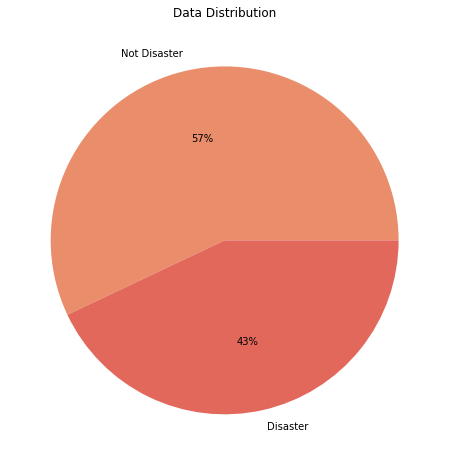

In [7]:
plt.figure(figsize=(8,8))
colors = sns.color_palette('flare')
plt.pie(x=df_train["target"].value_counts().values,labels=["Not Disaster", "Disaster"],autopct='%.0f%%', colors=colors)
plt.title("Data Distribution")
plt.show()

* The data doesn't seem to be awfully misbalanced
* Both of the classes have an _almost_ equal distribution. So we don't need to worry about creating a balanced dataset by either subsampling the data or some other data augmentation technique.

#### Missing values

In [8]:
???

Object `?` not found.


#### Keywords

In [9]:
keyword_distribution = df_train['keyword'].value_counts()
keyword_distribution[:10]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: keyword, dtype: int64

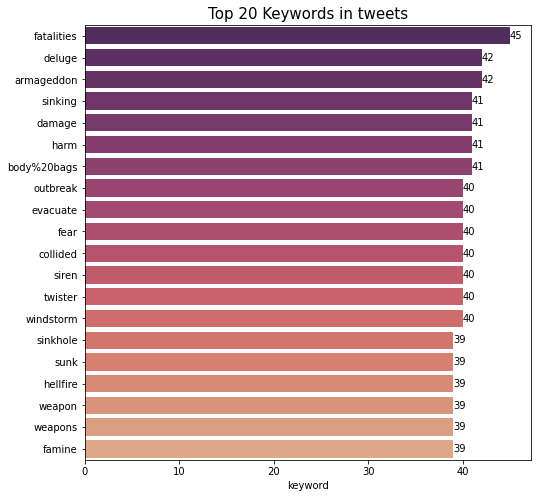

In [10]:
plt.figure(figsize=(8,8))

top_20_keywords=df_train['keyword'].value_counts()[:20]
ax = sns.barplot(y=top_20_keywords.index,x=top_20_keywords,palette='flare_r',data=df_train)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 20 Keywords in tweets',fontsize=15)
plt.show()

#### Keywords - Disaster vs Not Disaster

In [11]:
keywords_disaster = df_train.loc[df_train["target"] == 1]["keyword"].value_counts()
keywords_not_disaster = df_train.loc[df_train["target"] == 0]["keyword"].value_counts()

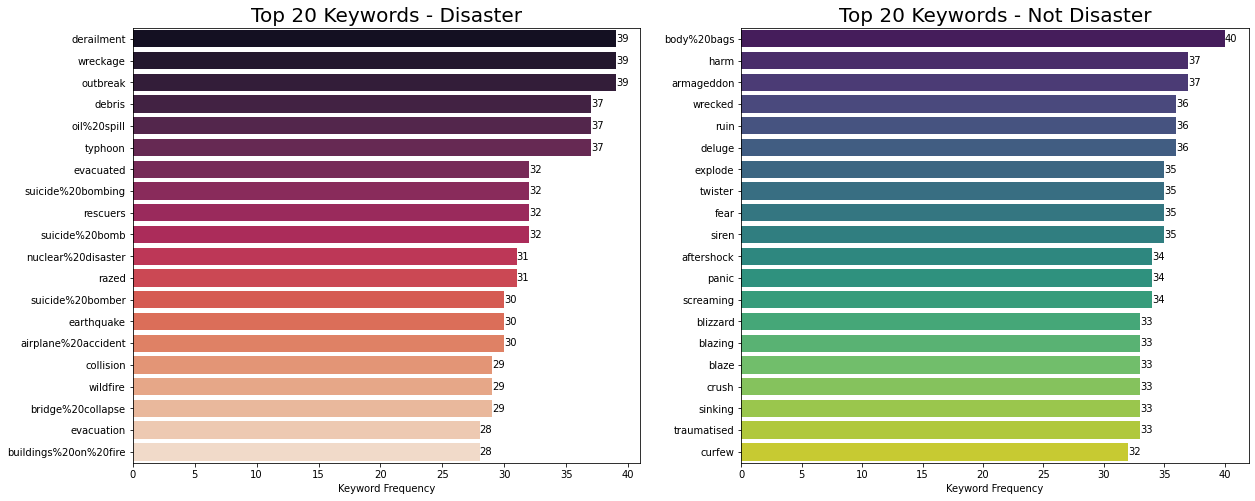

In [12]:
# plt.figure(figsize=(20,8))
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax1 = sns.barplot(y=keywords_disaster[0:20].index, x=keywords_disaster[0:20], orient='h', ax=ax[0], palette="rocket")
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title("Top 20 Keywords - Disaster",fontsize=20)
ax[0].set_xlabel("Keyword Frequency")

ax2 = sns.barplot(y=keywords_not_disaster[0:20].index, x= keywords_not_disaster[0:20], orient='h', ax=ax[1], palette="viridis")
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title("Top 20 Keywords - Not Disaster",fontsize=20)
ax[1].set_xlabel("Keyword Frequency")


plt.show()

#### Tweet Length and Word Counts

* Twitter has traditionally always had a hard limit of 140 character for tweets. Only a few years ago did they double the limit to 280.

In [13]:
df_train["length"] = df_train["text"].str.len()
df_train["word_count"] = df_train["text"].apply(lambda x: len(x.split()))

In [14]:
df_train.head()

,id,keyword,location,text,target,length,word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16


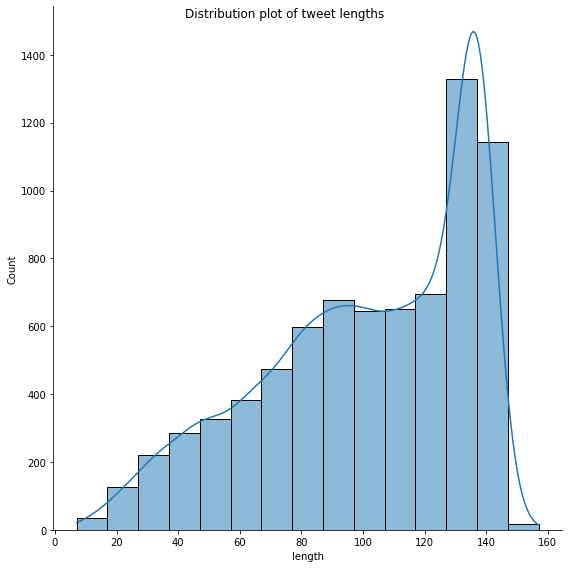

In [15]:
ax = sns.displot(df_train["length"],bins=15,kde=True, height=8)
ax.fig.suptitle('Distribution plot of tweet lengths')
plt.show()

In [16]:
df_train['length'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

* Average tweet length is 101 characters
* Longest tweet is 157 characters long

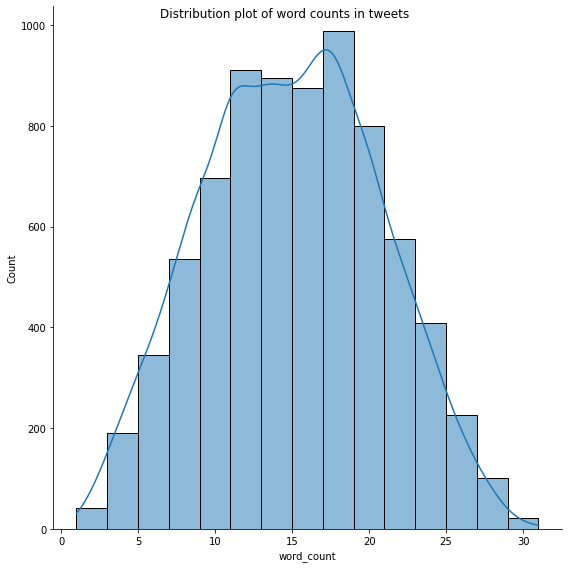

In [17]:
ax = sns.displot(df_train["word_count"],bins=15,kde=True, height=8)
ax.fig.suptitle('Distribution plot of word counts in tweets')
plt.show()

In [18]:
df_train['word_count'].describe()

count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: word_count, dtype: float64

* Average number of words per tweet is approx 15
* Max number of words per tweet is 31

### Preprocessing text for a ML Model

Cleanup process:
- Remove stopwords (from `nltk` library)
- Apply a stemming algorithm (`Porter` from `nltk` library)
- Remove punctuations
- Since we're dealing with raw tweets data, we'll also remove any emojis using regex

What is stemming?
- Stemming is the process of reducing variants to a root word
- For example: chocolates, chocolatey, choco can all be reduced to the same root word - `chocolate`